202599


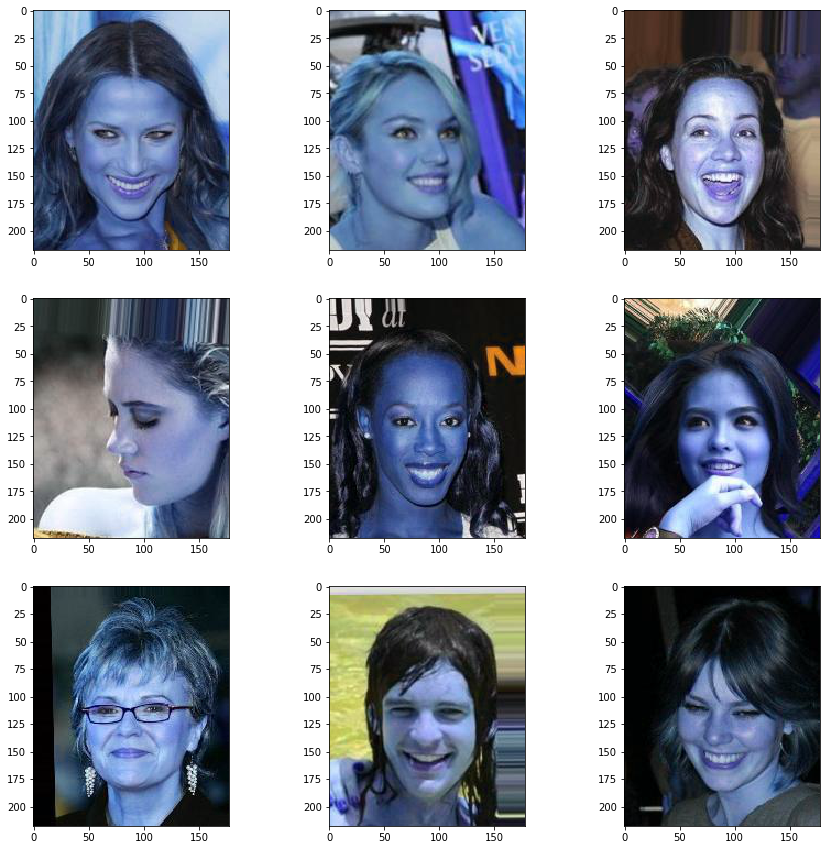

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

from tensorflow.contrib.data import Dataset, Iterator

import random
CELEBA_DATE_DIR = 'img_align_celeba'
train_images = []
for image_filename in os.listdir(CELEBA_DATE_DIR):
    if image_filename.endswith('.jpg'):
        train_images.append(os.path.join(CELEBA_DATE_DIR, image_filename))

random.shuffle(train_images)
 
batch_size = 64
num_batch = len(train_images) // batch_size
IMAGE_SIZE = 64
IMAGE_CHANNEL = 3


print(len(train_images))


# train_imgs = tf.constant(train_images)

# # create TensorFlow Dataset objects
# tr_data = Dataset.from_tensor_slices((train_imgs))



# def input_parser(img_path):
# #     # convert the label to one-hot encoding
# #     one_hot = tf.one_hot(label, NUM_CLASSES)

#     # read the img from file
#     img_file = tf.read_file(img_path)
#     img_decoded = tf.image.decode_image(img_file, channels=3)
#     image = tf.image.resize_images(img_decoded, (IMAGE_SIZE, IMAGE_SIZE))
#     image = image.astype('float32') / 127.5 - 1

#     return image

# tr_data = tr_data.map(input_parser)
# tr_data = tr_data.batch(batch_size)


# # create TensorFlow Iterator object
# iterator = Iterator.from_structure(tr_data.output_types,
#                                    tr_data.output_shapes)
# next_element = iterator.get_next()

# def load_All():
#     image_batch = np.zeros((len(train_images), IMAGE_SIZE, IMAGE_SIZE, 3))
#     i=0
#     for img in tqdm(train_images):
# #         arr = Image.open(img)
# #         arr = arr.resize((IMAGE_SIZE, IMAGE_SIZE))
# #         arr = np.array(arr)
# #         arr = arr.astype('float32') / 127.5 - 1
#         image = cv2.imread(img)
#         image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
#         image = image.astype('float32') / 127.5 - 1
# #         image_batch.append(image)
#         image_batch[i,:,:,:] = image
#         i+=1
        
#     return image_batch

    
def get_next_batch(pointer):
    image_batch = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))
    images = train_images[pointer*batch_size:(pointer+1)*batch_size]
    i=0
    for img in images:
#         arr = Image.open(img)
#         arr = arr.resize((IMAGE_SIZE, IMAGE_SIZE))
#         arr = np.array(arr)
#         arr = arr.astype('float32') / 127.5 - 1
        image = cv2.imread(img)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image.astype('float32') / 127.5 - 1
#         image_batch.append(image)
        image_batch[i,:,:,:] = image
        i+=1
        
    return image_batch

# x_train = load_All()

fig = plt.figure(figsize=(15,15))
for i in range(9):
    img = train_images[i]
    ax = fig.add_subplot(3,3,i+1)
    image = cv2.imread(img)
        
    ax.imshow(image)
    
    
    

In [2]:
from keras.models import Sequential
from keras.layers import Conv2DTranspose, Conv2D, Activation, Reshape, LeakyReLU, BatchNormalization, Flatten, Dense
from keras import backend as K
K.set_learning_phase(1) #set learning phase

def generator(noise, phase=True):
    with tf.variable_scope("Generator"):
        out1 = tf.contrib.layers.fully_connected(noise, 2*IMAGE_SIZE*IMAGE_SIZE,activation_fn=None, scope ="G_linear" )
        out1 = tf.reshape(out1, [-1, 4, 4, IMAGE_SIZE*8])
        out1 = tf.nn.relu(out1, name =  "G_relu1")
        
        out2 = tf.contrib.layers.conv2d_transpose(out1, IMAGE_SIZE*4, 5,stride=2, padding='SAME', scope = 'G_conv2')
        out2 = tf.contrib.layers.batch_norm(out2, center=True, scale=True, 
                                          is_training=phase, scope="G_BN2")
        out2 = tf.nn.relu(out2, name="G_relu2")    
        
        
        out3 = tf.contrib.layers.conv2d_transpose(out2, IMAGE_SIZE*2, 5,stride=2, padding='SAME', scope = 'G_conv3')
        out3 = tf.contrib.layers.batch_norm(out3, center=True, scale=True, 
                                      is_training=phase, scope="G_BN3")
        out3 = tf.nn.relu(out3, name="G_relu3")    
        
        out4 = tf.contrib.layers.conv2d_transpose(out3, IMAGE_SIZE, 5,stride=2, padding='SAME', scope = 'G_conv4')
        out4 = tf.contrib.layers.batch_norm(out4, center=True, scale=True, 
                                          is_training=phase, scope="G_BN4")
        out4 = tf.nn.relu(out4, name="G_relu4")  
        
        out5 = tf.contrib.layers.conv2d_transpose(out4, 3, 5,stride=2, padding='SAME', scope = 'G_conv5')
        out5 = tf.contrib.layers.batch_norm(out5, center=True, scale=True, 
                                          is_training=phase, scope="G_BN5")
        out5 = tf.nn.tanh(out5, name="G_relu5")    
        
#         out1 = Dense( 2*IMAGE_SIZE *IMAGE_SIZE)(noise)
#         out1 = Reshape((4, 4, IMAGE_SIZE*8))(out1)
#         out1 = Activation('relu')(out1)
    
#         out2 = Conv2DTranspose(256, 5, strides=(2,2), padding='SAME', use_bias=True)(out1)
#         out2 = BatchNormalization()(out2)
#         out2 = Activation('relu')(out2)
    
#         out3 = Conv2DTranspose(128, 5, strides=(2,2), padding='SAME', use_bias=True)(out2)
#         out3 = BatchNormalization()(out3)
#         out3 = Activation('relu')(out3)
    
#         out4 = Conv2DTranspose(64, 5, strides=(2,2), padding='SAME', use_bias=True)(out3)
#         out4 = BatchNormalization()(out4)
#         out4 = Activation('relu')(out4)
    
#         out5 = Conv2DTranspose(3, 5, strides=(2,2), padding='SAME', use_bias=True)(out4)
#         out5 = BatchNormalization()(out5)
#         out5 = Activation('tanh')(out5)
        
    return out5

# def generator(self, z):
#     self.z_, self.h0_w, self.h0_b = linear(z, self.gf_dim*8*4*4,
#                                            'g_h0_lin', with_w=True)

#     self.h0 = tf.reshape(self.z_, [-1, 4, 4, self.gf_dim * 8])
#     h0 = tf.nn.relu(self.g_bn0(self.h0))

#     self.h1, self.h1_w, self.h1_b = conv2d_transpose(h0,
#         [self.batch_size, 8, 8, self.gf_dim*4], name='g_h1', with_w=True)
#     h1 = tf.nn.relu(self.g_bn1(self.h1))

#     h2, self.h2_w, self.h2_b = conv2d_transpose(h1,
#         [self.batch_size, 16, 16, self.gf_dim*2], name='g_h2', with_w=True)
#     h2 = tf.nn.relu(self.g_bn2(h2))

#     h3, self.h3_w, self.h3_b = conv2d_transpose(h2,
#         [self.batch_size, 32, 32, self.gf_dim*1], name='g_h3', with_w=True)
#     h3 = tf.nn.relu(self.g_bn3(h3))

#     h4, self.h4_w, self.h4_b = conv2d_transpose(h3,
#         [self.batch_size, 64, 64, 3], name='g_h4', with_w=True)

#     return tf.nn.tanh(h4)


# def generator():
        
#     G = Sequential()
#     G.add( Dense( 2*IMAGE_SIZE *IMAGE_SIZE, input_dim=100))
    
#     G.add(Reshape((4,4,IMAGE_SIZE*8)))
#     G.add( Activation('relu'))
     
#     G.add(Conv2DTranspose(IMAGE_SIZE*4, 5, strides=(2,2), padding='SAME', use_bias=True))
#     G.add(BatchNormalization())
#     G.add( Activation('relu'))
    
    
#     G.add( Conv2DTranspose(IMAGE_SIZE*2, 5, strides=(2,2), padding='SAME', use_bias=True))
#     G.add(BatchNormalization())
#     G.add( Activation('relu'))
    
    
#     G.add( Conv2DTranspose(IMAGE_SIZE, 5, strides=(2,2), padding='SAME', use_bias=True))
#     G.add(BatchNormalization())
#     G.add( Activation('relu'))
    
#     G.add( Conv2DTranspose(IMAGE_CHANNEL, 5, strides=(2,2), padding='SAME', use_bias=True))
#     G.add(BatchNormalization())
#     G.add( Activation('tanh'))
    
# #     G.summary()

#     return G


Using TensorFlow backend.


In [3]:
# def discriminator(self, image, reuse=False):
#     if reuse:
#         tf.get_variable_scope().reuse_variables()

#     h0 = lrelu(conv2d(image, self.df_dim, name='d_h0_conv'))
#     h1 = lrelu(self.d_bn1(conv2d(h0, self.df_dim*2, name='d_h1_conv')))
#     h2 = lrelu(self.d_bn2(conv2d(h1, self.df_dim*4, name='d_h2_conv')))
#     h3 = lrelu(self.d_bn3(conv2d(h2, self.df_dim*8, name='d_h3_conv')))
#     h4 = linear(tf.reshape(h3, [-1, 8192]), 1, 'd_h3_lin')

#     return tf.nn.sigmoid(h4), h4

def discriminator(input_images, reuse=False, phase = True):
   
    
#     with tf.variable_scope("Discriminator" ,reuse = reuse) as scope:
#         if reuse:
#             scope.reuse_variables()
        
#         if reuse:
#             scope.reuse_variables()

    if reuse:
        tf.get_variable_scope().reuse_variables()
    
    out1 = tf.contrib.layers.conv2d(input_images,IMAGE_SIZE, 5,stride=2, padding='SAME',  scope="D_conv1" )
    out1 = tf.nn.leaky_relu(out1, name="D_LK1")
    
    out2 =  tf.contrib.layers.conv2d(out1, IMAGE_SIZE*2, 5,stride=2, padding='SAME',  scope="D_conv2" )
    out2 = tf.contrib.layers.batch_norm(out2, center=True, scale=True, 
                                          is_training=phase, scope="D_BN2")
    out2 = tf.nn.leaky_relu(out2, name="D_LK2")    

    out3 =   tf.contrib.layers.conv2d(out2,IMAGE_SIZE*4, 5,stride=2, padding='SAME',  scope="D_conv3" )
    out3 = tf.contrib.layers.batch_norm(out3, center=True, scale=True, 
                                          is_training=phase, scope="D_BN3")
    out3 = tf.nn.leaky_relu(out3, name="D_LK3")   
    
    out4 =  tf.contrib.layers.conv2d(out3,IMAGE_SIZE*8, 5,stride=2, padding='SAME',  scope="D_conv4" )
    out4 = tf.contrib.layers.batch_norm(out4, center=True, scale=True, 
                                          is_training=phase, scope="D_BN4")
    out4 = tf.nn.leaky_relu(out4, name="D_LK4")   
#     out1 = Conv2D( IMAGE_SIZE, 5, strides=(2,2), padding='SAME', use_bias=True)(input_images)
# #         out1 = BatchNormalization()(out1)
#     out1 = LeakyReLU(0.2)(out1)

#     out2 = Conv2D( IMAGE_SIZE*2, 5, strides=(2,2), padding='SAME', use_bias=True)(out1)
#     out2 = BatchNormalization()(out2)
#     out2 = LeakyReLU(0.2)(out2)

#     out3 = Conv2D( IMAGE_SIZE*4, 5, strides=(2,2), padding='SAME', use_bias=True)(out2)
#     out3 = BatchNormalization()(out3)
#     out3 = LeakyReLU(0.2)(out3)

#     out4 = Conv2D( IMAGE_SIZE*8, 5, strides=(2,2), padding='SAME', use_bias=True)(out3)
#     out4 = BatchNormalization()(out4)
#     out4 = LeakyReLU(0.2)(out4)
    
    out5 = tf.reshape(out4, [-1, 8192])
    out5 = tf.contrib.layers.fully_connected(inputs=out5,num_outputs=1,activation_fn=None, scope='D_linear')
    
#     out5 = Flatten()(out4)
#     out5 = Dense(8192)(out5)

    out6 =tf.nn.sigmoid(out5, name="D_sigmoid")


    return out6,out5
#    
# def discriminator():
#     D = Sequential()

#     D.add( Conv2D(64, 5, strides=(2,2), padding='SAME', use_bias=True) ,input_dim=(IMAGE_SIZE, IMAGE_SIZE,IMAGE_CHANNEL))
#     D.add(LeakyReLU(alpha=0.2))
    
    
#     D.add( Conv2D(128, 5, strides=(2,2), padding='SAME', use_bias=True))
#     D.add(BatchNormalization())
#     D.add(LeakyReLU(alpha=0.2))
    
#     D.add( Conv2D(256, 5, strides=(2,2), padding='SAME', use_bias=True))
#     D.add(BatchNormalization())
#     D.add(LeakyReLU(alpha=0.2))

    
#     D.add( Conv2D(512, 5, strides=(2,2), padding='SAME', use_bias=True))
#     D.add(BatchNormalization())
#     D.add(LeakyReLU(alpha=0.2))

    
#     D.add(Flatten())
#     D.add(Dense(1))
#     D.add(Activation('sigmoid'))
    
   
    
#     return D
    
    

In [4]:
from keras.models import Model, Input
from keras.optimizers import Adam, RMSprop


# noise =  Input(shape=(z_dim,), dtype='float32')
 
# fake_image = generator(noise)
# _, fake_decoded = discriminator(fake_image)
# model_A = Model(noise, fake_decoded)


z_dim = 100

z = Input(shape=(z_dim,), dtype='float32')
# Images = Input(shape=(None,IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL), dtype = 'float32')
is_training = tf.placeholder(tf.bool, name='is_training')
Images = tf.placeholder(
            tf.float32, [None,IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL], name='real_images')
G = generator(z, phase=is_training)

with tf.variable_scope("Discriminator" ) as scope:
    D, D_logits = discriminator(Images, reuse=False, phase = is_training)
    scope.reuse_variables()
    D_,D_logits_ = discriminator(G, reuse =True, phase = is_training)



d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits, labels = tf.ones_like(D)))

d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits_,labels = tf.zeros_like(D_)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits_,labels = tf.ones_like(D_)))

t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'Discriminator' in var.name]
g_vars = [var for var in t_vars if 'Generator' in var.name]


learning_rate = 0.001
lr_decay = 0.9
beta1 = 0.9

d_optim = tf.train.AdamOptimizer(learning_rate) \
                    .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(learning_rate) \
                    .minimize(g_loss, var_list=g_vars)

In [5]:
d_vars

[<tf.Variable 'Discriminator/D_conv1/weights:0' shape=(5, 5, 3, 64) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv2/weights:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN2/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN2/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv3/weights:0' shape=(5, 5, 128, 256) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv3/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN3/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN3/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv4/weights:0' shape=(5, 5, 256, 512) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv4/biases:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable '

In [6]:
g_vars

[<tf.Variable 'Generator/G_linear/weights:0' shape=(100, 8192) dtype=float32_ref>,
 <tf.Variable 'Generator/G_linear/biases:0' shape=(8192,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv2/weights:0' shape=(5, 5, 256, 512) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv2/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN2/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN2/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv3/weights:0' shape=(5, 5, 128, 256) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv3/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN3/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN3/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv4/weights:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv4/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN4/gamma:0' shape=(64,) dtype=floa

In [ ]:
import time
model_save_path = './gan_model.ckpt'

saver = tf.train.Saver()
with tf.Session() as sess:
    print("start")
#     sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_save_path)

    step = 0
    for i in range(1):
        print("start ", i)
        for j in range(num_batch):
            t0 = time.time()
            batch_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, z_dim]).astype(np.float32)
            image_batch = get_next_batch(j)
            
            d_loss_, _ = sess.run([d_loss, d_optim], feed_dict={z: batch_noise, Images:image_batch, is_training: True})
            g_loss_, _ = sess.run([g_loss, g_optim], feed_dict={z: batch_noise, Images:image_batch, is_training: True})
            g_loss_, _ = sess.run([g_loss, g_optim], feed_dict={z: batch_noise, Images:image_batch, is_training: True})
 


            
#             if step % 100 == 0:
            print(step, d_loss_, g_loss_, time.time()-t0)
 
            if step % 100 == 0:
                
                test_noise = np.random.uniform(-1.0, 1.0, size=(5, z_dim)).astype(np.float32)
                fig = plt.figure(figsize=(15,5))
                
                images = sess.run(G, feed_dict={z: test_noise, is_training: True})
                for k in range(5):
                    image = images[k, :, :, :]
                    image += 1
                    image *= 127.5
                    image = np.clip(image, 0, 255).astype(np.uint8)
                    image = np.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, -1))
                    ax =fig.add_subplot(1,5,k+1)
                    ax.imshow(image)
                    
                save_path = saver.save(sess, save_path= model_save_path)
                print("Model saved in file: %s" % save_path)
                
                learning_rate = learning_rate * lr_decay
                
            
            
            step += 1
            
            if step>2000:
                break

# for epoch in xrange(1):
#     for idx in xrange(0, batch_idxs):
#         batch_images = ...
#         batch_z = np.random.uniform(-1, 1, [config.batch_size, self.z_dim]) \
#                     .astype(np.float32)

#         # Update D network
#         _, summary_str = self.sess.run([d_optim, self.d_sum],
#             feed_dict={ self.images: batch_images, self.z: batch_z })

#         # Update G network
#         _, summary_str = self.sess.run([g_optim, self.g_sum],
#             feed_dict={ self.z: batch_z })

#         # Run g_optim twice to make sure that d_loss does not go to zero
#         # (different from paper)
#         _, summary_str = self.sess.run([g_optim, self.g_sum],
#             feed_dict={ self.z: batch_z })

#         errD_fake = self.d_loss_fake.eval({self.z: batch_z})
#         errD_real = self.d_loss_real.eval({self.images: batch_images})
#         errG = self.g_loss.eval({self.z: batch_z})

start
INFO:tensorflow:Restoring parameters from ./gan_model.ckpt
start  0
0 0.0113365 11.7276 14.371906757354736
Model saved in file: ./gan_model.ckpt
1 0.0122917 11.2364 19.883464813232422
2 0.00259741 9.72021 11.93776249885559
3 0.000348686 8.76595 11.817538261413574
4 0.00127563 7.93091 11.763849020004272
5 0.0023149 6.42384 11.166491746902466
6 0.0058449 5.91356 11.496929168701172
7 0.00555611 6.16129 11.186076879501343
8 0.00439589 6.68619 11.282084703445435
9 0.0316812 6.77629 10.970335245132446
10 0.00620439 6.49003 13.033126831054688
11 0.0100039 7.98081 10.903395891189575
12 0.00129204 9.25778 11.767826795578003
13 0.00718177 9.88388 11.81921911239624
14 0.00227841 9.49649 10.911357402801514
15 0.0214576 8.91758 12.748808145523071
16 0.0269544 7.98934 11.041643142700195
17 0.0022312 7.056 10.702878952026367
18 0.0021919 6.48635 11.325326204299927
19 0.0146458 6.34577 11.349938869476318
20 0.00790508 5.54031 10.905339479446411
21 0.028332 8.69855 11.073333978652954
22 0.0014355

199 0.0114252 6.02998 9.847647666931152
200 0.0100899 6.92502 9.88771653175354
Model saved in file: ./gan_model.ckpt
201 0.00728637 7.84188 18.229236841201782
202 0.00213484 8.27868 10.24885082244873
203 0.00118393 8.37548 10.382777690887451
204 0.00127976 7.8014 10.248125076293945
205 0.00543388 7.32637 10.758435249328613
206 0.00373081 6.93495 10.136325359344482
207 0.00440227 6.61917 10.141849756240845
208 0.00541461 7.03559 9.822453022003174
209 0.00388953 7.65447 9.938393354415894
210 0.00161397 8.05309 9.949909687042236
211 0.00233966 7.91322 9.668882846832275
212 0.00298984 7.60634 9.842085123062134
213 0.017334 7.12855 10.152811050415039
214 0.0042831 6.59854 9.7660551071167
215 0.0112714 6.21865 9.898988246917725
216 0.0166447 6.3124 10.138412237167358
217 0.00976758 6.90224 9.934051513671875
218 0.00561597 7.35298 9.840294122695923
219 0.00715 8.06396 9.890712022781372
220 0.00770642 8.36023 9.715023279190063
221 0.00502356 8.16932 10.01185655593872
222 0.00253566 7.81931 9.9

405 0.705731 2.81876 14.558634042739868
406 0.597775 2.4032 14.35555362701416
407 0.650011 3.78587 9.951497077941895
408 0.59692 4.8605 10.84525203704834
409 0.371935 5.33518 10.450846910476685
410 0.41309 3.98714 9.704658031463623
411 0.393824 3.20395 9.910536289215088
412 0.510369 5.19561 9.893114805221558
413 0.340289 7.57174 9.814852714538574
414 0.619802 7.55801 9.434603929519653
415 0.775965 5.48539 10.04787302017212
416 0.401816 4.14783 9.781956672668457
417 0.345756 4.48015 9.7322838306427
418 0.135279 5.54837 9.805521011352539
419 0.462195 6.15783 9.862821817398071
420 0.161081 7.42293 9.67860460281372
421 0.156505 7.35786 9.97623610496521
422 0.0880266 5.85666 9.751440525054932
423 0.546382 5.31417 9.572115898132324
424 0.99506 7.68693 9.776377201080322
425 0.718466 7.10225 9.84479308128357
426 2.11649 1.80372 9.836362361907959
427 1.94055 10.7979 9.714770793914795
428 1.35836 9.50165 9.488496541976929
429 0.666392 3.88871 9.708502292633057
430 2.00827 9.14672 9.7149267196655

617 0.195931 4.1288 9.602779388427734
618 1.01812 6.69697 9.64441728591919
619 0.569863 9.7508 9.591900825500488
620 0.589753 9.48554 9.53285551071167
621 0.616138 3.30315 9.325761079788208
622 1.10784 5.53004 10.26761794090271
623 0.332559 8.10189 9.578946590423584
624 0.475652 6.31111 9.562249183654785
625 0.563604 4.05947 9.590571165084839
626 0.439536 3.59859 9.463008165359497
627 0.736161 5.25418 9.940685272216797
628 0.472737 7.03625 9.695772886276245
629 1.83714 3.97142 9.453968048095703
630 0.800277 2.19291 9.593463897705078
631 1.00638 5.63574 11.380216598510742
632 0.422395 7.4237 9.463007688522339
633 0.569485 7.60569 9.4295072555542
634 1.64202 3.07246 9.493508100509644
635 1.30107 4.87382 9.79066252708435
636 0.234727 6.39845 9.614282846450806
637 0.0714717 6.84392 9.453368902206421
638 1.13763 4.9746 9.514501571655273
639 0.319774 4.04507 9.388692140579224
640 0.408109 4.7135 9.388334512710571
641 0.178578 5.15093 9.942283868789673
642 0.415028 5.26241 9.34824538230896
64

829 0.672894 4.11223 10.117760181427002
830 0.323551 5.57648 9.635209798812866
831 0.158053 6.97894 9.831279516220093
832 0.473056 5.84762 9.82973337173462
833 0.489267 2.92442 9.719904899597168
834 0.626919 2.397 9.628865718841553
835 0.974535 4.88141 9.763412714004517
836 0.343026 7.51685 10.41351056098938
837 0.510236 7.84528 9.653660535812378
838 1.97928 3.34219 9.645392656326294
839 0.768739 2.3192 12.798398971557617
840 1.44784 3.50921 14.406395435333252
841 0.586339 6.18502 15.701340913772583
842 0.642872 6.96236 11.186276912689209
843 1.2602 6.3286 10.408671140670776
844 0.459053 4.97635 9.764795780181885
845 0.413362 3.56907 9.704156160354614
846 0.801225 4.61432 10.139454364776611
847 0.465291 6.39421 9.70014500617981
848 0.356175 8.36606 9.514609575271606
849 0.332241 7.87945 9.939543962478638
850 0.391784 5.39834 10.373634099960327
851 0.539522 4.04213 10.04283881187439
852 0.652963 4.61454 9.851151704788208
853 0.288868 5.7879 10.939998626708984
854 0.554215 4.87201 10.006

1039 0.250394 4.34753 9.400632619857788
1040 0.475695 4.27472 9.586751699447632
1041 0.528551 3.90758 9.342702388763428
1042 0.507076 3.84209 9.44315218925476
1043 1.26265 2.30284 9.310470581054688
1044 1.38859 3.12346 9.314881801605225
1045 1.05002 4.49325 9.532901763916016
1046 0.356854 5.63444 9.59937310218811
1047 0.663515 5.38142 9.423966407775879
1048 0.391749 5.45058 9.4594144821167
1049 0.478591 3.58472 9.643146753311157


In [10]:
print(tf.train.get_checkpoint_state(model_save_path ))

None
